In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50, ResNet50_Weights

from torchvision.ops import FeaturePyramidNetwork

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from tqdm import tqdm

import numpy as np

import os

import matplotlib.pyplot as plt

from utils.dataset import Dataset

from scipy.stats import pearsonr as corr

from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression


In [2]:
batch_size = 10

In [3]:
data = Dataset('../../data/subj08')
test_data = Dataset('../../data/subj08', test=True)

train_set, val_set = torch.utils.data.random_split(data, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 8779
Test images: 395

LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)
Loading dataset sample names...
Training images: 8779
Test images: 395

LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)


In [4]:
# loading pretrained model
device = torch.device("cuda")

model = resnet50(weights=ResNet50_Weights.DEFAULT)

layer_names = []

for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer_names += [name]

print(layer_names)

feature_extractor = create_feature_extractor(model, 
        return_nodes=["layer2.3.conv3"]).to(device)

feature_extractor.eval()

['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.0.downsample.0', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3', 'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3', 'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3', 'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3', 'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3', 'layer4.0.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3', 'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3']


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Module(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [5]:
class RegressionHead(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(RegressionHead, self).__init__()
        # linear layers for regression outputs
        self.linear1 = torch.nn.Linear(inputSize, 1028)
        self.linear2 = torch.nn.Linear(1028, 2048)
        self.linear3 = torch.nn.Linear(2048, outputSize)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return self.linear3(x)

In [6]:
feature_extractor(data[0][0].to(device).unsqueeze(0))["layer2.3.conv3"].shape

torch.Size([1, 512, 28, 28])

In [7]:
regression_head = RegressionHead(512*28*28, 18981).to(device)
regression_head.to(device)

RegressionHead(
  (linear1): Linear(in_features=401408, out_features=1028, bias=True)
  (linear2): Linear(in_features=1028, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=18981, bias=True)
)

In [8]:
#lf_fmri = []

def fit_pca(feature_extractor, dataloader):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=400, batch_size=400)

    curr_stack = None

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if _ == len(dataloader)-1:
            break
        
        # Saves memory
        with torch.no_grad():
            # Extract features
            ft = feature_extractor(d[0].to(device))
        
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])

        if curr_stack == None:
            curr_stack = ft
        else:
            curr_stack = torch.vstack([curr_stack, ft])

        if (_ + 1) % (400 / batch_size) == 0 and _ != 1:
            print(curr_stack.shape)
            # Fit PCA to batch
            pca.partial_fit(curr_stack.detach().cpu().numpy())
            curr_stack = None

    return pca

In [9]:
pca = fit_pca(feature_extractor, train_loader)

  4%|▍         | 39/878 [00:04<01:37,  8.59it/s]

torch.Size([400, 401408])


  9%|▉         | 79/878 [00:48<01:29,  8.97it/s]  

torch.Size([400, 401408])


: 

: 

In [ ]:
def extract_features(feature_extractor, dataloader, pca):
    lh_fmri = []
    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if _ == len(dataloader)-1:
            break
        
        with torch.no_grad():
            # Extract features
            ft = feature_extractor(d[0].to(device))
            
        lh_fmri += [d[1].cpu().detach().numpy()]
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features += [ft]
        
    return (np.vstack(features), np.vstack(lh_fmri))

In [ ]:
features_train, labels_train = extract_features(feature_extractor, train_loader, pca)
features_val, labels_val = extract_features(feature_extractor, val_loader, pca)

In [40]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(regression_head.parameters(), lr=0.0001)

In [41]:
losses = []

for epoch in range(10):
    print(f"Epoch {epoch}")
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        image = data[0].to(device)
        label = data[1].to(device)

        optimizer.zero_grad()

        output = feature_extractor(image)["layer2.3.conv3"]
        output = regression_head(torch.flatten(output, start_dim=1))

        loss = criterion(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

Epoch 0


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 1


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 2


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 3


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 4


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:33<00:00,  1.07s/it]


Epoch 5


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 6


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.08s/it]


Epoch 7


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 8


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Epoch 9


  0%|          | 0/88 [00:00<?, ?it/s]

0


100%|██████████| 88/88 [01:34<00:00,  1.07s/it]


Text(0.5, 1.0, 'Loss over time, lr=0.0001, epochs=10, batch_size=100')

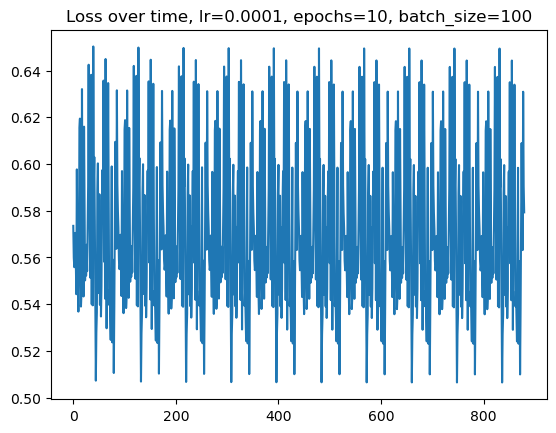

In [45]:
plt.plot(losses, label="Loss")
plt.title("Loss over time, lr=0.0001, epochs=10, batch_size=100")